In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
from Bio import SeqIO
import collections
import sys

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import random

sys.path.append("..")
from evaluation_metrics import *
from data_processing import *

#Human Sequences
fasta = '../../../data/human_sequences.fasta'
test_set_file = '../../../data/human_annotations_temporal_holdout.mat'

sequences, names = load_FASTA(fasta)
train_inds, valid_inds, test_inds, y_trainHuman, y_validHuman, y_testHuman, go_termsHuman = load_test_sets(test_set_file)

train_seqsHuman = [sequences[i] for i in train_inds]
print('Number of training prots: ' + str(len(train_seqsHuman)))
valid_seqsHuman = [sequences[i] for i in valid_inds]
print('Number of validation prots: ' + str(len(valid_seqsHuman)))
test_seqsHuman = [sequences[i] for i in test_inds]
print('Number of testing prots: ' + str(len(test_seqsHuman)))

#Yeast sequences
fasta = '../../../data/yeast_sequences.fasta'
test_set_file = '../../../data/yeast_MF_temporal_holdout.mat'

sequences, names = load_FASTA(fasta)
train_inds, valid_inds, test_inds, y_trainYeast, y_validYeast, y_testYeast, go_termsYeast = load_test_sets(test_set_file)

train_seqsYeast = [sequences[i] for i in train_inds]
print('Number of training prots: ' + str(len(train_seqsYeast)))
valid_seqsYeast = [sequences[i] for i in valid_inds]
print('Number of validation prots: ' + str(len(valid_seqsYeast)))
test_seqsYeast = [sequences[i] for i in test_inds]
print('Number of testing prots: ' + str(len(test_seqsYeast)))

Number of training prots: 9751
Number of validation prots: 3871
Number of testing prots: 1647
Number of training prots: 3447
Number of validation prots: 963
Number of testing prots: 206


In [43]:
embed_dim_list = []
hidden_size = []
l2_penalty = []
learning_rate = []

for i in range(5):
    embed_dim_list.append(np.random.randint(200, 301))
    hidden_size.append(np.random.randint(500, 1001))
    l2_penalty.append(np.random.uniform(0.0001, 0.001))
    learning_rate.append(np.random.uniform(0.0001, 0.001))
    
embed_dim_list, hidden_size, l2_penalty, learning_rate

([218, 223, 250, 254, 218],
 [986, 707, 732, 746, 576],
 [0.00040721143246818517,
  0.0008320611748322755,
  0.0005083741909918379,
  0.0007147996536374936,
  0.0009426272656596279],
 [0.0004666407616485299,
  0.0003622387531994863,
  0.0005813305214044742,
  0.00024066326726184109,
  0.0006285439928364301])

In [2]:
yTrainHuman = torch.from_numpy(y_trainHuman).type(torch.LongTensor)
yValidHuman = torch.from_numpy(y_validHuman).type(torch.LongTensor)
yTestHuman = torch.from_numpy(y_testHuman).type(torch.LongTensor)

#yTrainYeast

# Calculating the Length of train, valid and test data 

In [23]:
k = 1 #value for kmers

train_seqsHuman_length = sequence_lengths_with_kmers(train_seqsHuman, k) 
valid_seqsHuman_length = sequence_lengths_with_kmers(valid_seqsHuman, k)
test_seqsHuman_length = sequence_lengths_with_kmers(test_seqsHuman, k)

## Vectorize all amino-acid chains in the list 
#### Each amino-acid string becomes one row in a tensor object.
#### This tensor object has dimension NxD, where N is the number of amino-acid strings and D is the length of the longest chain in the set. 

## Get kmers (Can take upto 3-4 mins)

In [24]:
k_mers_human = get_k_mers(train_seqsHuman, valid_seqsHuman, test_seqsHuman, k)

### Runs quickly for Yeast, about 2 minutes for Human data. 

In [25]:
# This can take a while for k >= 2
TrainSeqsHuman = TransformAAsToTensor_with_kmers(train_seqsHuman, k, k_mers_human)
ValidSeqsHuman = TransformAAsToTensor_with_kmers(valid_seqsHuman, k, k_mers_human)
TestSeqsHuman = TransformAAsToTensor_with_kmers(test_seqsHuman, k, k_mers_human)
#TestSeqsHuman

## Convert to cuda

In [26]:
# use_cuda = torch.cuda.is_available()

if use_cuda == True:
    ValidSeqsHuman = ValidSeqsHuman.cuda()
    ValidSeqsYeast = ValidSeqsYeast.cuda()
    yValidHuman = yValidHuman.cuda()
    yValidYeast = yValidYeast.cuda()
    TrainSeqsHuman = TrainSeqsHuman.cuda()
    TrainSeqsYeast = TrainSeqsYeast.cuda()
    yTrainHuman = yTrainHuman.cuda()
    yTrainYeast = yTrainYeast.cuda()
    TestSeqsHuman = TestSeqsHuman.cuda()
    TestSeqsYeast = TestSeqsYeast.cuda()
    yTestHuman = yTestHuman.cuda()
    yTestYeast = yTestYeast.cuda()
    

NameError: name 'use_cuda' is not defined

# Train Model

## 0) Hyperparameter setting

In [27]:
learning_rate = 0.001
#vocab_size = 26 # number words in the vocabulary base
# vocab_size = len(acid_dict) + len(k_mers_human)
vocab_size = max(list(k_mers_human.values()))
emb_dim = 50 # dimension for n-gram embedding
num_epochs = 5 # number epoch to train
batch_size = 26

In [ ]:
np.array([[0.4, 0.5, 0.6],
          [0.5, 0.4, 0.3],
          [0.3, 0.3, 0.4]])

np.array([[1, 0, 0],
          [0, 0, 1],
          [0, 1, 1]])

## 1) Get batch data method:


## 3) GRU Implementation

In [28]:
class RNN_GRU(nn.Module):
    """
    GRU model
    """
       
    def __init__(self, vocab_size, emb_dim, num_labels, hidden_size, n_layers=1, dropout=0.1, is_bidirectional = False):
       
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(RNN_GRU, self).__init__()

        self.num_labels = num_labels
        self.num_directions = 1 # it is 2 if the rnn is bidirectional
        self.hidden_size = hidden_size
        self.is_bidirectional = is_bidirectional
        self.dropout = nn.Dropout(p=dropout)
        self.embed = nn.Embedding(vocab_size+1, emb_dim, padding_idx=0)
        self.gru = nn.GRU(emb_dim, hidden_size, n_layers, dropout, bidirectional=is_bidirectional)
        self.linear = nn.Linear(self.num_directions*hidden_size, num_labels)
        
    
    def forward(self, input_seqs):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        embedded = self.embed(input_seqs) # size = (max_length, batch_size, embed_size)
        #packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths) # size = (max_length * batch_size, embed_size)
        
        hidden = None
        outputs, hidden = self.gru(embedded, hidden) # outputs are supposed to be probability distribution right?
        #print(outputs.size(), hidden.size())
        #outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        if self.is_bidirectional == True:
            outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
            
        last_hidden = self.dropout(outputs[-1,:,:].squeeze())            
        #output_probability = torch.nn.functional.sigmoid(self.linear(last_hidden))
        output_probability = torch.nn.functional.softmax(self.linear(last_hidden))
        
        return output_probability # size : (batch_size, num_labels)
    
                

## 4) Training Stage

In [31]:
def early_stop(val_acc_history, t=2, required_progress=0.00001):
    """
    Stop the training if there is no non-trivial progress in k steps
    @param val_acc_history: a list contains all the historical validation acc
    @param required_progress: the next acc should be higher than the previous by 
        at least required_progress amount to be non-trivial
    @param t: number of training steps 
    @return: a boolean indicates if the model should earily stop
    """
    # TODO: add your code here
    
    cnt = 0 # initialize the count --> to store count of cases where difference in
                                    #  accuracy is less than required progress.
    
    if(len(val_acc_history) > 0): # if list has size > 0 
        for i in range(t): # start the loop
            index = len(val_acc_history) - (i+1) # start from the last term in list and move to the left
            if (index >= 1): # to check if index != 0 --> else we can't compare to previous value
                if (abs(val_acc_history[index] - val_acc_history[index-1]) < required_progress):
                    cnt += 1 # increase the count value
                else:
                    break # break if difference is grea-ter 
    
    if(cnt != t): # if count is equal to t, return True
        return False
    else:
        return True
    
    
def train(valid_sequences, valid_label, num_epochs, optimizer, data_iter, model, training_length, threshold):
    losses = []
    total_batches = int(training_length/ batch_size) #375
    
    # Storing f-score, precision, recall, accuracy for every threshold.
    #validation_acc_history = [[] for i in range(len(threshold))]
    validation_losses = []
    F_scores = []
    calculated_f_score = np.zeros(len(threshold))
    max_precision = np.zeros(len(threshold))
    max_recall = np.zeros(len(threshold))
    
    for epoch in range(1, num_epochs+1):
        stop_training = False
        for i, (train_data, train_labels, length_batch) in enumerate(data_iter):
                                                # train_data size: (26, 34350) ; train_label size: (26, 147)
                                                # This needs to be modified. Max length is batch specific !!!!!
            model.train(True)
            model.zero_grad()
            outputs = model(train_data.transpose(0,1))
            loss = criterion(outputs, train_labels.float())
            losses.append(loss.data[0])
            loss.backward()
            
            
            clipped = torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
            # clip gradients because RNN
            for pr in model.parameters():
                pr.data.add_(-clipped, pr.grad.data)
            
            optimizer.step()
            
            if i%eval_every == 0:
#                 # Erly stop using validation loss
                model.eval()
                val_outputs = model(Variable((valid_sequences).transpose(0,1).type(torch.LongTensor), volatile=True))
                eval_loss = criterion(val_outputs.data, valid_label.type(torch.FloatTensor))
                print(eval_loss.data[0])
                validation_losses.append(eval_loss.data[0])
                stop_training = early_stop(validation_losses, 3)
                
#                 # Early stop using F-score (Yet to be done)
#                 ave_precision = average_precision(val_outputs, Variable(valid_label), th)
#                 ave_recall = average_recall(val_outputs, Variable(valid_label), th)
#                 if ave_precision == 0 or ave_recall == 0:
#                     f_score = 0
#                 else:
#                     f_score = F_score(ave_precision, ave_recall)
#                 print(f_score)
#                 F_scores.append(f_score)
#                 stop_training = early_stop(F_scores, 3)
                
            
            # Print statements
            if stop_training:
                print("earily stop triggered")
                break
            if (i+1) % print_every == 0:
#                 print('Epoch: [{0}/{1}], Step: [{2}/{3}], Train loss: {4}, F_Score: {5}, Validation loss:{6}'.format( 
#                            epoch, num_epochs, i+1, total_batches, np.mean(losses)/(total_batches*epoch), np.max(calculated_f_score), np.mean(np.array(validation_acc_history)[:,-1])))
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Train loss: {4}, Validation loss:{5}'.format( 
                           epoch, num_epochs, i+1, total_batches, np.mean(losses)/(total_batches*epoch), np.mean(np.array(validation_losses))))
        if stop_training == True:
            break
            
    #return calculated_f_score, max_precision, max_recall

## 5) Training the model

## Training stage

In [32]:
data_size = len(train_seqsHuman) #9751
num_labels = go_termsHuman.shape[0] #147
hidden_size = 50
eval_every = 2
print_every = 5

model = RNN_GRU(vocab_size, 10, num_labels, hidden_size, n_layers=1, dropout=0.1, is_bidirectional=False)
# if use_cuda:
#     model = model.cuda()

criterion = nn.MultiLabelSoftMarginLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [33]:
data_iter = batch_iter(batch_size, TrainSeqsHuman, yTrainHuman, train_seqsHuman_length)

num_epochs = 1
threshold = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1]

# Model Training
ValidSeqsHuman_small, yValidHuman_small = reduced_set(ValidSeqsHuman, valid_seqsHuman_length, yValidHuman, 100)
#f2, p2, r2 = train(ValidSeqsHuman_small, yValidHuman_small, num_epochs, optimizer, data_iter, model, data_size, threshold)
train(ValidSeqsHuman_small, yValidHuman_small, num_epochs, optimizer, data_iter, model, data_size, threshold)

0.6962615847587585
0.6962617635726929
0.6962593793869019
Epoch: [1/1], Step: [5/375], Train loss: 0.0018569398244222004, Validation loss:0.696260909239451
0.6962609887123108
earily stop triggered


## 6) Testing performance on test data

In [34]:
def test_set_predictions(model, test_input_seq):
    model.eval()
    test_input_seq = Variable(test_input_seq)
    predicted = model(test_input_seq.transpose(0,1).type(torch.LongTensor))
    return predicted

In [35]:
test_predictions = test_set_predictions(model, TestSeqsHuman)
#FScore, Threshold, Precision, Recall = F_score(test_set_predictions, yTestHuman)

In [36]:
plot_AUPR_curve(test_predictions.data.numpy(), yTestHuman.numpy(), label='GRU', org='Human')

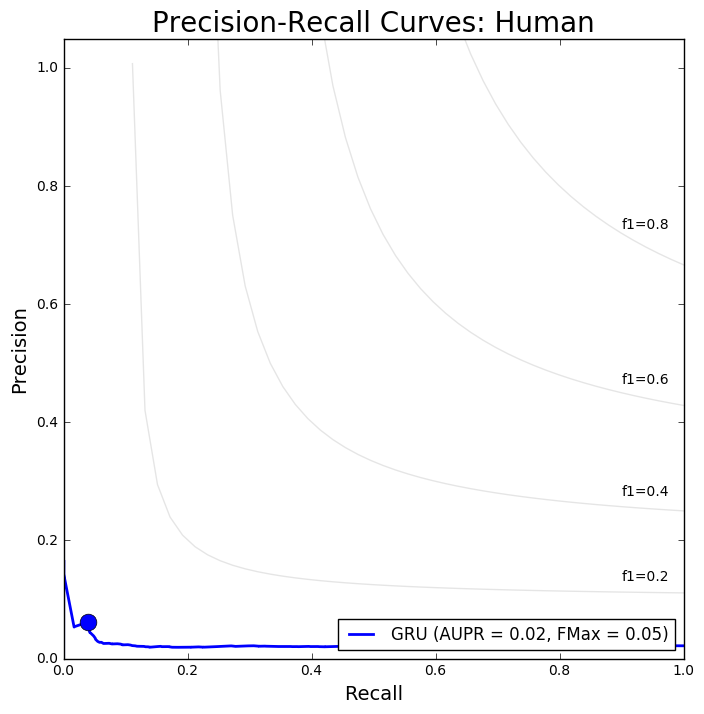

In [37]:
plt.show()

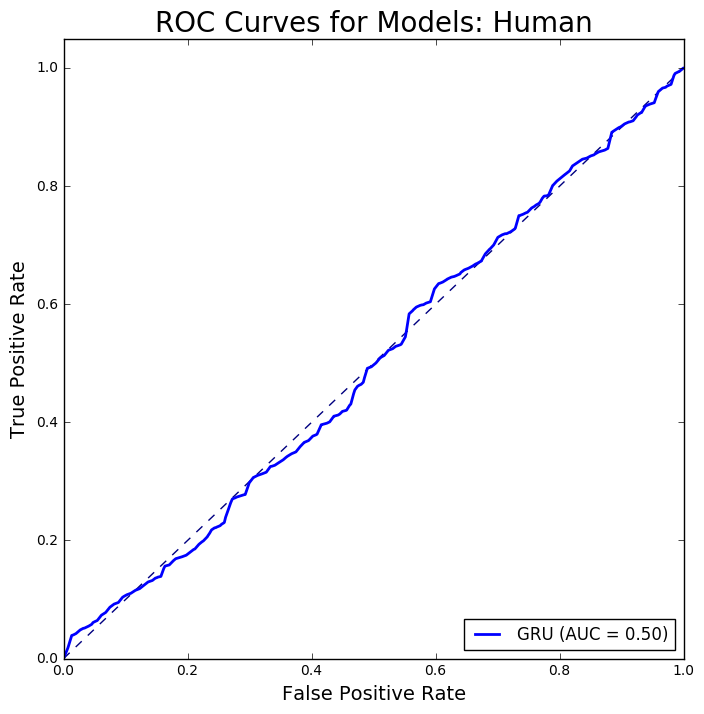

In [38]:
plot_AUC_curve(test_predictions.data.numpy(), yTestHuman.numpy(), label='GRU', org='Human')
plt.show()